In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import numpy as np

    !pip install yfinance
    import yfinance as yf

    import matplotlib.pyplot as plt

    ''' NN '''

    from sklearn.datasets import make_regression
    import sklearn
    from sklearn import preprocessing, model_selection
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import MinMaxScaler

    import random

    import torch
    import matplotlib.pyplot as plt
    import os

    from tqdm import tqdm

    import torch.nn as nn
    import torch.optim as optim
    from collections import Counter
    import torch.nn.functional as F
    from datetime import datetime
    !pip install livelossplot

# New LSTM

In [ ]:
# TPU cluster from GoogleColab 

# import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

from livelossplot import PlotLossesKeras
import plotly.graph_objects as go

In [7]:
stock = 'ROSN.ME'
start = '2008-02-01'
end = '2020-11-12'

df = yf.download(stock, start=start, end=end)
df.shape

[*********************100%***********************]  1 of 1 completed


(2676, 6)

In [8]:
data = df.filter(['Close'])
data_frame = data
data = data.values

train_len = round(len(data)*0.8)
train_len

2141

In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(data)

In [10]:
train_data = train_scaled[0:train_len, :]

x_train = []
y_train = []

window = 60

for i in range(window, len(train_data)):
  x_train.append(train_data[i-window:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
test_data = train_scaled[train_len-60:, :]

x_test =[]
y_test = data[train_len:, :]

for i in range(window, len(test_data)):
  x_test.append(test_data[i-window:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
model = Sequential()

model.add(LSTM(units = 512, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 32, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

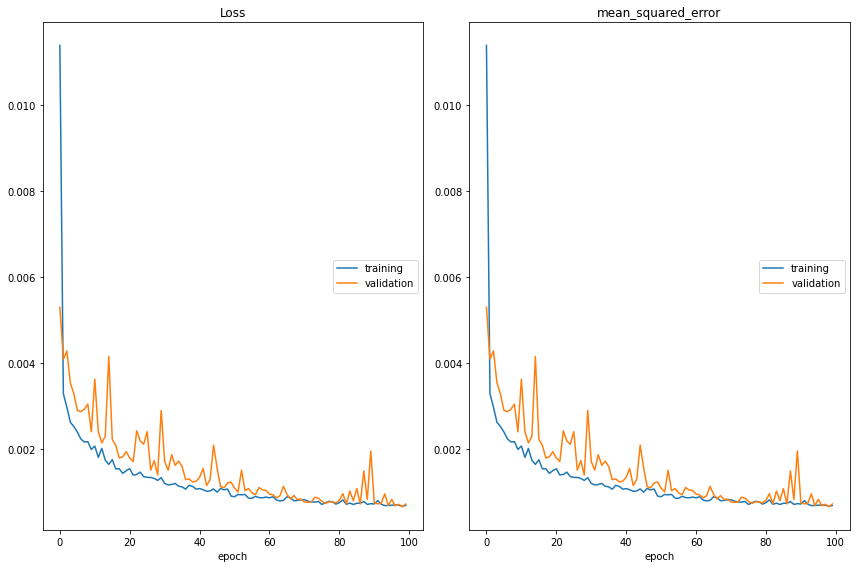

Loss
	training         	 (min:    0.001, max:    0.011, cur:    0.001)
	validation       	 (min:    0.001, max:    0.005, cur:    0.001)
mean_squared_error
	training         	 (min:    0.001, max:    0.011, cur:    0.001)
	validation       	 (min:    0.001, max:    0.005, cur:    0.001)
52/52 [==============================] - 1s 26ms/step - loss: 6.9313e-04 - mean_squared_error: 6.9313e-04 - val_loss: 7.2573e-04 - val_mean_squared_error: 7.2573e-04
mean_squared_error: 0.001262046797783114


In [24]:
optim_Adam = keras.optimizers.Adam(learning_rate=0.0001)
callback = EarlyStopping(monitor = 'loss', patience = 25, restore_best_weights=True)

model.compile(optimizer=optim_Adam, loss='mean_squared_error', metrics=['mean_squared_error'])

history = model.fit(x_train, y_train, validation_split = 0.2, batch_size=32, epochs=100, 
                    callbacks = [callback, PlotLossesKeras()], shuffle=True, verbose=1)

print(f'mean_squared_error:', np.mean(history.history['mean_squared_error']))

In [25]:
# from google.colab import files
# !ls

# name = 'gpu_model_weights_14-08-2022.h5'
# model.save_weights(name)
# files.download(name)

# # model = create_models()
# # model.load_weights(name)

sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [28]:
diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))

MSE: 263.30043918669014
MAE: 10.616635559652453
RMSE: 16.226535033293157


In [29]:
train = data_frame[:train_len].copy()
valid = data_frame[train_len:].copy()
valid['Pred'] = predictions

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Close'], name='train close', fillcolor='blue'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], name='valid close', fillcolor='red'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Pred'], name='valid predicitions', fillcolor='green'))

fig.update_layout(xaxis_range=['2018-06-01', '2020-12-31'])

fig.show()

In [31]:
next_data = yf.download(stock, start=start, end=end)

new_df = next_data.filter(['Close'])

prediction_days = 20

future_pred = np.array([])
last_60 = new_df[-window:].values

for i in range(prediction_days):

  last_60 = last_60[-window:]
  last_60_sc = sc.transform(last_60)

  x_ = []

  x_.append(last_60_sc)
  x_ = np.array(x_)
  x_ = np.reshape(x_, (x_.shape[0], x_.shape[1], 1))

  pred = model.predict(x_)
  pred = sc.inverse_transform(pred)

  future_pred = np.append(future_pred, pred)
  last_60 = np.vstack((last_60, pred))

[*********************100%***********************]  1 of 1 completed


In [32]:
future_pred

array([401.90444946, 409.09344482, 413.02624512, 414.24417114,
       414.29376221, 414.56713867, 415.572052  , 416.98547363,
       418.21179199, 418.9135437 , 419.17776489, 419.33843994,
       419.69116211, 420.32479858, 421.1434021 , 421.99993896,
       422.81512451, 423.60961914, 424.45727539, 425.41720581])

In [33]:
future_data = yf.download(stock, period='max')
future_days = prediction_days+30

future_data_transform = future_data[future_data.index >= end].head(future_days).copy()
future_data_transform = future_data_transform[['Close']].copy()

future_df = future_data[future_data.index >= end].head(prediction_days).copy()
future_df['predictions'] = future_pred
future_df = future_df[['Close', 'predictions']].copy()

future_df['difference'] = future_df['Close'] - future_df['predictions']

[*********************100%***********************]  1 of 1 completed


In [34]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], name='real close'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Pred'], name='test predicitions'))

fig.add_trace(go.Scatter(x=future_df.index, y=future_df['predictions'], name='future predicitions'))
fig.add_trace(go.Scatter(x=future_data_transform.index, y=future_data_transform['Close'], 
                         name=f'future real {future_days} days'))

fig.update_layout(xaxis_range=['2020-01-01', '2021-04-01'])

fig.show()

In [35]:
future_df

,Close,predictions,difference
Date,,,
2020-11-12,416.049988,401.904449,14.145538
2020-11-13,417.299988,409.093445,8.206543
2020-11-16,429.899994,413.026245,16.873749
2020-11-17,439.500000,414.244171,25.255829
2020-11-18,456.250000,414.293762,41.956238
2020-11-19,448.000000,414.567139,33.432861
2020-11-20,461.600006,415.572052,46.027954
2020-11-23,469.149994,416.985474,52.164520
2020-11-24,472.000000,418.211792,53.788208


## GridSearchCV

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
# !pip install scikeras[tensorflow]

In [ ]:
# from scikeras.wrappers import KerasClassifier, KerasRegressor
# from sklearn.utils.multiclass import type_of_target
# # type_of_target(y_train)
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# def create_model():
#   global X_train
#   model = Sequential()
#   model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#   model.add(Dropout(0.6))
#   model.add(LSTM(units = 128, return_sequences = True))
#   model.add(Dropout(0.6))
#   model.add(LSTM(units = 64, return_sequences = True))
#   model.add(Dropout(0.6))
#   model.add(LSTM(units = 16))
#   model.add(Dropout(0.6))
#   model.add(Dense(units = 1))
#   # model.summary()
#   model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'mean_squared_error')
#   return model

In [ ]:
# start_time = datetime.now()

# model = KerasRegressor(model = create_model, verbose=2, epochs=5)

# batch = [16, 32]
# param = dict(batch_size = batch)

# grid = GridSearchCV(estimator = model, param_grid = param, cv = 3, n_jobs = -1, 
#                           scoring = 'neg_mean_squared_error', refit=False, verbose=2)

# grid_result = grid.fit(X_train, y_train)

# print(f'\n Время на вычисление: {datetime.now() - start_time} \n')
# print(f' best_params: {grid_result.best_params_}')

# Linear NN

In [ ]:
stock = 'ROSN.ME'
data = yf.download(stock, '2008-01-01', '2022-05-20')

data

In [ ]:
x_data = data[['Open', 'High', 'Low', 'Adj Close', ]]
y_data = data['Close']

Xy = pd.concat([x_data, y_data], axis=1)

Xy.corr().style.background_gradient(cmap='YlGnBu')

In [ ]:
Scaler = MinMaxScaler(feature_range = (0, 1))
X_scaler = Scaler.fit_transform(np.array(x_data))

max = Scaler.data_max_
min = Scaler.data_min_

X_scaler # Scaler.inverse_transform

In [ ]:
# x = X_scaler

x = np.array(x_data)
y = np.array(y_data)

x.shape, y.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, y_test.shape

In [ ]:
x_train, x_test, y_train, y_test = x[:2432], x[2432:], y[:2432], y[2432:]
x_train.shape, y_test.shape

In [ ]:
def NN(n_feat = 4, n_layer = [128, 32, 16], learning_rate = 0.001, epochs = 100, y_pr=True, get_test_pred=True):

    class Model(nn.Module):
        def __init__(self):
            super().__init__()                
            self.linear = nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_feat, n_layer[0], bias=True),
                nn.ReLU(),
                nn.Linear(n_layer[0], n_layer[1], bias=True),
                nn.ReLU(),
                nn.Linear(n_layer[1], n_layer[2], bias=True),
                # nn.ReLU(),
                nn.Linear(n_layer[2], 1, bias=True),
                )
                
        def forward(self, x):
            return self.linear(x)
                
                
    model = Model()    
    X = torch.tensor(x_train).float()
    # y = torch.tensor(y_train).float()
    y = torch.tensor(y_train.reshape(x_train.shape[0], 1)).float()
    
    # criterion = nn.MSELoss()
    criterion = nn.L1Loss()


    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    items = []

    ''' '''
    
    for epoch in tqdm(range(epochs)):

        y_pred = model(X)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        items.append(loss.item())
 
    ''' '''

    list_y_pred = y_pred
    ic(f'{epoch} {round(loss.item(), 5)}')
    y_pred = list((np.array(  y_pred.detach().clone()  )).reshape(1, X.shape[0])[0])


    plt.figure(figsize=(19, 12))
    plt.subplot(221)
    plt.plot(items[:], 'b')
    plt.subplot(222)
    plt.plot(y[-70:], 'g')
    plt.plot(y_pred[-70:], 'r')
    

    yy = pd.DataFrame(list(np.array(y)), columns=['y'])
    yy_pred = pd.DataFrame(list(np.array(y_pred)), columns=['y_pred'])
    dat = pd.concat([yy_pred, yy], axis=1)
    dat['y_pred-y'] = dat['y'] - dat['y_pred']
    dat['mean()'] = np.mean([-1 * i for i in dat['y_pred-y'] if i<0])
      
    # if get_test_pred==False:
    #         y_test_pred = model(x_test)
    #         ic(pd.DataFrame([y_test, y_test_pred]))
    
    if y_pr == False:
        return dat, list_y_pred, model

    else:
        return dat

In [ ]:
dat, y_pr, model_test = NN(n_feat = x.shape[1], n_layer = [700, 100, 10], learning_rate = 0.001, epochs = 150, y_pr=False, get_test_pred=True)
dat

In [ ]:
test = x[:]
test = torch.tensor(test).float()
test